# Aim: Look if can apply mask of test06 to test 05

# Denoising SWOT data with a first order penalization filter 
* L. Gómez Navarro, E. Cosme, J. Le Sommer and A. Monsimer
* Started on 31 March 2017, last update on 19th July 2017

## Objective

This notebook illustrates the implementation of a first order penalization filter provided by N. Papadakis to filter out noise from SWOT data. It applies the filter for a given lambda and number of iterations, and saves the filtered data in a netCDF file. This notebook is adapted for the BOX selected SWOT dataset.

## Input and output data

SWOT data here comes in the form of a NetCDF files from the SWOT ocean simulator. In this case 1km grid resolution BOX selected dataset is used.  It can be downloaded here:

The file can be downloaded here: 

xxxxxxxx

The output is similar, containing the filtered fields.


## Related links

* https://github.com/SWOTsimulator

# Filtering Method description 
##### (Image denoising, N. Papadakis, March 2017)

### 1. Tikhonov regularization
We consider a noisy image $h_{obs}$ that we want to restore. We assume that the image $h_{obs}$ corresponds to a clean “ground truth” image $h_0$ that has been perturbed by an additional white Gaussian noise $ε$ so that: $h_{obs} = h_0 + ε$. To do so, one can consider the Tikhonov regularization of the gradient of the image and try to minimize the functional:
<br>
<br>
$$ J(h) = \frac{1}{2} \Vert h - h_{obs} \Vert ^2 + \frac{\lambda}{2} \Vert \nabla h \Vert ^2 $$
<br>
<br>
To optimize this convex problem, a simple gradient descent algorithm can be performed.
We have:
<br>
<br>
$$ \langle \nabla J(h),dh \rangle = \lim_{\epsilon\to0} \frac{J (h + \epsilon dh) - J(h)}{\epsilon} $$


### 2. Adaptation to SSH denoising
Let h denote a SSH map. From geostrophic balance one can assume that $v ∝ ∇^⊥ h$, where $v$ is the surface velocity. In this case, one has $ξ ∝ ∆h$, where $ξ$ is the relative vorticity, that is assumed spatially smooth. In the previous model, by regularizing the gradient of $h$, we are looking for a solution where $||∇h||$ is small, i.e. where the norm of the velocity field is small. This may be a bad regularization model.
Hence, a physically sound model to restore a noisy SSH map $h_{obs}$ could be to regularize the gradient of the vorticity, i.e. the gradients of the laplacian of the image:

<br>
$$ J(h) = \frac{1}{2}||h − h_{obs}||^2  +  \frac{λ}{2}||∇∆h||^2 $$
<br>
This problem can still be solved with a gradient descent algorithm that now reads:

<br>
$$h^{k+1} = h^k + τ(h_{obs} − h^k + λ∆∆∆h^k)$$
<br>
, and $τ$ should be taken as: $τ < 1/(1 + 512λ)$ to ensure the convergence of the algorithm.


# Loading the necesssary modules:

In [10]:
import glob
from netCDF4 import Dataset
import xarray as xr

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap

from shutil import copyfile
import os

%pylab inline

#from scipy import ndimage
from scipy import ndimage as nd

Populating the interactive namespace from numpy and matplotlib


# Defining the necessary functions:

In [11]:
def gradi(I): 
    """
    Calculates the gradient in the x-direction of an image I and gives as output M.
    In order to keep the size of the initial image the last row is left as 0s.
    """
    
    m, n = I.shape
    M = np.zeros([m,n])

    M[0:-1,:] = np.subtract(I[1::,:], I[0:-1,:])
    return M

def gradj(I): 
    """
    Calculates the gradient in the y-direction of an image I and gives as output M.
    In order to keep the size of the initial image the last column is left as 0s.
    """
    
    m, n = I.shape
    M = np.zeros([m,n])
    M[:,0:-1] =  np.subtract(I[:,1::], I[:,0:-1])
    return M


In [12]:
def div(px, py): 
    """
    Calculates the divergence of a vector (px, py) and gives M as ouput
    ; where px and py have the some size and are the gradient in x and y respectively 
    of a variable p.
    The x component of M (Mx) first row is = to the first row of px.
    The x component of M (Mx) last row is = to - the before last row of px. (last one = 0)
    The y component of M (My) first column is = to the first column of py.
    The y component of M (My) last column is = to - the before last column of py. (last one = 0)
    ??#(de sorte que div=-(grad)^*)
    """
    m, n = px.shape
    M = np.zeros([m,n])
    Mx = np.zeros([m,n])
    My = np.zeros([m,n])
 
    Mx[1:m-1, :] = px[1:m-1, :] - px[0:m-2, :]
    Mx[0, :] = px[0, :]
    Mx[m-1, :] = -px[m-2, :]

    My[:, 1:n-1] = py[:, 1:n-1] - py[:, 0:n-2]
    My[:, 0] = py[:,0]
    My[:, n-1] = -py[:, n-2]
     
    M = Mx + My;
    return M

def laplacian(u):
    """
    Calculates the laplacian of u using the divergence and gradient functions and gives 
    as output Ml.
    """
    Ml = div(gradi(u), gradj(u));
    return Ml

def trilaplacian(u):
    u2 = laplacian(laplacian(laplacian(u)))
    
    return u2

In [13]:
def gaussian_with_nans(u, sigma):
    '''
    Evan Mason
    http://stackoverflow.com/questions/18697532/gaussian-filtering-a-image-with-nan-in-python
    '''
    assert np.ma.any(u.mask), 'u must be a masked array'
    mask = np.flatnonzero(u.mask)
    #u.flat[mask] = np.nan

    v = u.data.copy()
    #v.flat[mask] = 0
    v[:] = nd.gaussian_filter(v ,sigma=sigma)

    w = np.ones_like(u.data)
    w.flat[mask] = 0
    w[:] = nd.gaussian_filter(w, sigma=sigma)

    return v/w

# Loading first test 05 (simulation with gap):

In [14]:
datadir = '/Users/laura/src/git/swotsimulator/swotoutput/FASTtest05/'
input_filename_test05_c1p09 = 'MED_fastPhase_1km_swotFAST_c01_p009.nc'

In [15]:
myfile = datadir + input_filename_test05_c1p09

In [16]:
##====================== Load SWOT data ========================

xds = xr.open_dataset(myfile, engine='netcdf4', lock=False)
lon = xds.lon
lat = xds.lat
SSH_model = xds.SSH_model
SSH_obs = xds.SSH_obs
x_ac = xds.x_ac

##=================Preparing the SWOT data arrays===============
# 5. Masking the SWOT outputs
lon = lon.to_masked_array()
lat = lat.to_masked_array()
SSH_model = SSH_model.to_masked_array() 
SSH_obs = SSH_obs.to_masked_array()
x_ac = x_ac.to_masked_array()

SSH_model = np.ma.masked_invalid(SSH_model)
SSH_obs = np.ma.masked_invalid(SSH_obs)

# 2. Flipping the SWOT array: 
# So that lon increases from left to right and lat from bottom to top 
# (depends on if pass is ascending or descending)

lon_dif = lon[0,1] - lon[0,0]
lat_dif = lat[1,0] - lat[0,0]

if (lat_dif<0):
    ## Ascending pass (pass 22 for in the fast-sampling phase)        
    lon = np.flipud(lon)
    lat = np.flipud(lat)
    SSH_model = np.flipud(SSH_model)
    SSH_obs = np.flipud(SSH_obs)
elif (lon_dif<0):
    ## Descending pass (pass 9 for in the fast-sampling phase)
    lon = np.fliplr(lon)
    lat = np.fliplr(lat)
    SSH_model = np.fliplr(SSH_model)
    SSH_obs = np.fliplr(SSH_obs)

# 1. Checking swot array is organized lon, lat: 
lon = np.transpose(lon)
lat = np.transpose(lat)
SSH_model = np.transpose(SSH_model)
SSH_obs = np.transpose(SSH_obs)

# 4. Longitude in -180 : +180 format:
lon[lon > 180] -= 360 

# 3. Fixing the SWOT grid (regular longitude increments, i.e., no jump in swath gap or repeated nadir values)
# At a 1km resolution, should have a size of 121 across track (size of first dim after transposing)    
xx, yy = lon.shape

SWOT_grid_resolution = abs(x_ac[1] - x_ac[0]) # pixel size in km
nhalfswath = np.shape(lon)[0]/2 # number of pixels in a swath
gap_distance = x_ac[nhalfswath] - x_ac[nhalfswath-1] - SWOT_grid_resolution # distance in km between the 2 swaths
gap_pixels = gap_distance / SWOT_grid_resolution
x_ac_nogap = np.arange(x_ac[0], x_ac[-1]+SWOT_grid_resolution, SWOT_grid_resolution)

gap_values = np.ma.zeros((gap_pixels, yy))
gap_values.mask = True
gap_values.fill_value = 0

if (lon[(xx/2)-1, 0] == lon [xx/2, 0]): 
    # if no gap simulaton case need to eliminate repeated nadir value
    lon_nogap = np.delete(lon, (xx/2), axis=0)
    lat_nogap = np.delete(lat, (xx/2), axis=0)
    SSH_model_nogap = np.delete(SSH_model, (xx/2), axis=0)
    SSH_obs_nogap = np.delete(SSH_obs, (xx/2), axis=0)

else:

    # Inserting 0 all masked values in the half swath gap:
    lon_gap = np.insert(lon, nhalfswath, gap_values, axis=0)
    lat_gap = np.insert(lat, nhalfswath, gap_values, axis=0)
    SSH_model_gap = np.insert(SSH_model, nhalfswath, gap_values, axis=0)
    SSH_obs_gap = np.insert(SSH_obs, nhalfswath, gap_values, axis=0)
    
    # where indent back???
    
    mask_gap = np.zeros((xx, yy), dtype=bool) # create all False array
    mask_gap = np.insert(mask_gap, nhalfswath, np.ones((gap_pixels, yy), dtype=bool), axis=0)
    
    # Need to mask invalid again:
    SSH_model_gap = np.ma.masked_invalid(SSH_model_gap)
    SSH_obs_gap = np.ma.masked_invalid(SSH_obs_gap)
    
    # If land falls within the gap, won't be able to inlcude it in mask_land
    mask_land = SSH_model_gap.mask
    
    # Convert land mask values to 0:
    SSH_model_gap[mask_land] = 0
    SSH_obs_gap[mask_land] = 0
    
    # Re-apply mask:
    SSH_model_gap = np.ma.masked_where(mask_land, SSH_model_gap)
    SSH_obs_gap = np.ma.masked_where(mask_land, SSH_obs_gap)
    
    # Apply gap mask:
    lon_gap = np.ma.masked_where(mask_gap, lon_gap)
    lat_gap = np.ma.masked_where(mask_gap, lat_gap)
    SSH_model_gap = np.ma.masked_where(mask_gap, SSH_model_gap)
    SSH_obs_gap = np.ma.masked_where(mask_gap, SSH_obs_gap)
    
    mask_gap_land = SSH_model_gap.mask
    
    # Setting fill_value to zero:
    lon_gap.fill_value = 0
    lat_gap.fill_value = 0
    SSH_model_gap.fill_value = 0
    SSH_obs_gap.fill_value = 0
    

/Users/laura/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:92: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


In [17]:
# Filling the masked values (gap and land):
sigma = 10
SSH_model_gap_gausf = gaussian_with_nans(SSH_model_gap, sigma)
SSH_obs_gap_gausf = gaussian_with_nans(SSH_obs_gap, sigma)

SSH_model_gap_full = SSH_model_gap.data.copy()
SSH_obs_gap_full = SSH_obs_gap.data.copy()

SSH_model_gap_full[mask_gap_land] = SSH_model_gap_gausf[mask_gap_land]
SSH_obs_gap_full[mask_gap_land] = SSH_obs_gap_gausf[mask_gap_land] # SSH_obs_nogap.mask

/Users/laura/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in divide


(0.0, 121.0, 0.0, 1342.0)

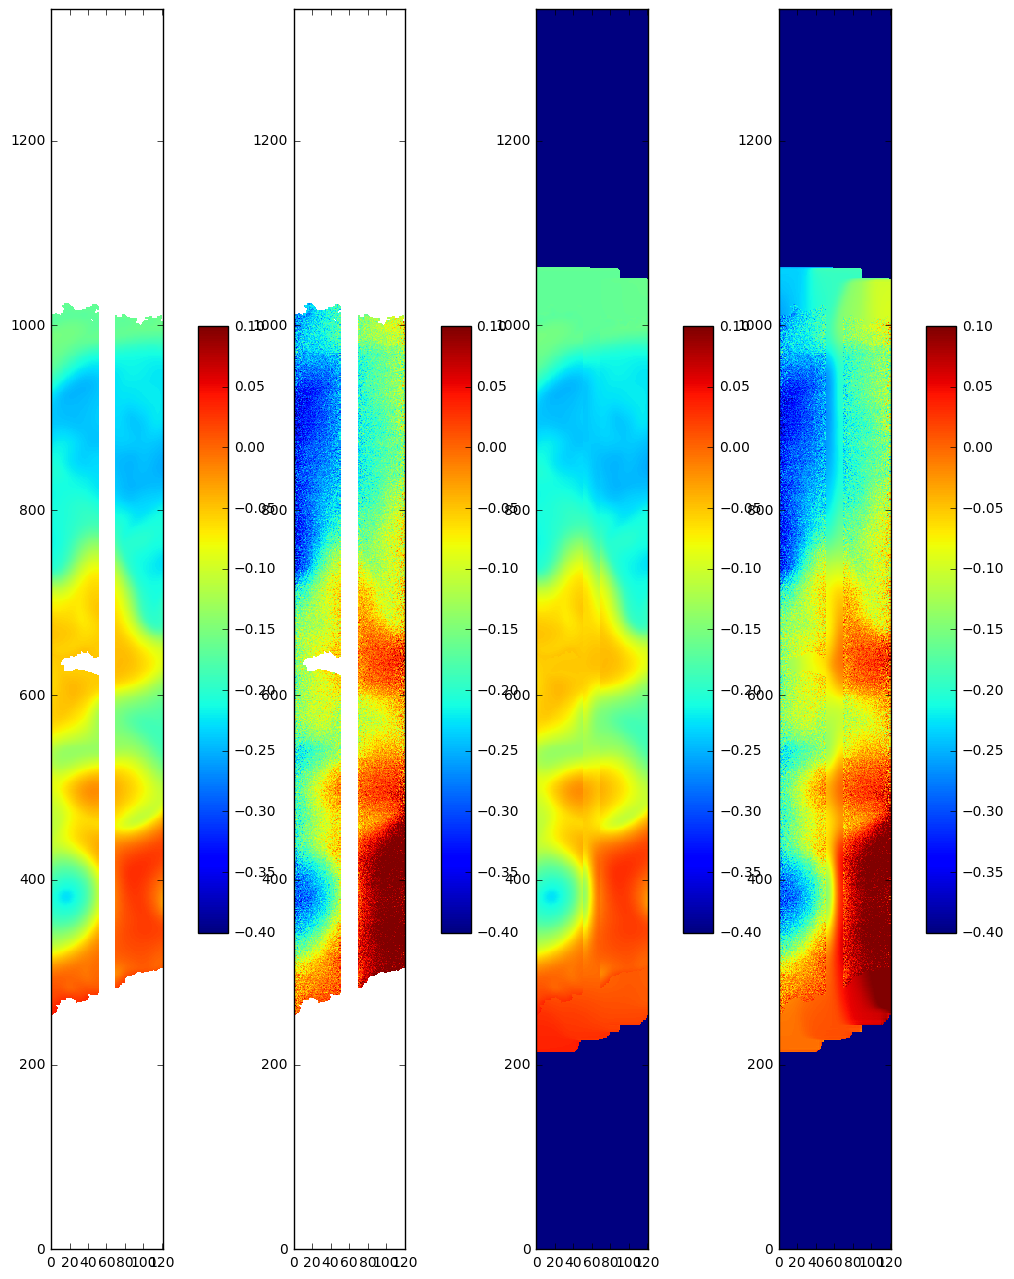

In [18]:
plt.figure(figsize=(12, 16))
plt.subplot(141)
plt.pcolor(SSH_model_gap.T, vmin = -.4, vmax=.1)
plt.colorbar()
plt.axis('image')
plt.subplot(142)
plt.pcolor(SSH_obs_gap.T, vmin = -.4, vmax=.1)
plt.colorbar()
plt.axis('image')
plt.subplot(143)
plt.pcolor(SSH_model_gap_full.T, vmin = -.4, vmax=.1)
plt.colorbar()
plt.axis('image')
plt.subplot(144)
plt.pcolor(SSH_obs_gap_full.T, vmin = -.4, vmax=.1)
plt.colorbar()
plt.axis('image')

In [15]:
def filtering(var=SSH_obs_gap_full, mask_of_data=mask_gap_land, var_obs=SSH_obs_gap, lambd=40
              , regularization_model=1, iter_max=500, epsilon=0.000001):
    '''
    
    -Input(s):
    --var = variable to be filtered
    Default = 
    --mask_of_data = array of True and False values.  0 when land or swath gap values.
    Default = 
    --var_obs = orginal data without filling the masked values 
    --lambd = lambda: regularization parameter (the larger lambda, the more regular is the denoised image).  
    This parameter needs to be adapted to the regularization model. 
    --regularization_model = 0 if Tikhonov regularization (first order penalization, i.e. gradient penalization) 
    and 1 if third order penalization (regularization of vorticity)
    --iter_max = maximum number of iterations in case it takes very long to converge
    --epsilon = 
    -Output(s):
    --ima1 = filtered image
    --itern = number of iterations realized until convergence
    '''
    
    ima0 = var
    ima_obs = var_obs
    
    mask01 = np.ones_like(var)
    mask01[mask_of_data] = 0
    
    if regularization_model == 0:
        tau = 1./(8*lambd)
        operator = laplacian
    elif regularization_model == 1:
        tau=1./(512*lambd)
        operator = trilaplacian
    else:
        print "Undefined regularization model"
    
    itern = 1
    ima1 = ima0 + tau*(mask01 * (ima_obs - ima0) + lambd*operator(ima0))

    norm_minus = np.nansum((ima1 - ima0)**2) + np.nansum((ima1 - ima0)**2)
    norm_ima0 = np.nansum((ima0)**2) + np.nansum((ima0)**2)
    conv_crit = norm_minus / norm_ima0

    while conv_crit > epsilon:
        ima0 = np.copy(ima1)
        itern = itern + 1
        ima1 = ima0 + tau*(mask01 * (ima_obs - ima0) + lambd*operator(ima0))
        norm_minus = np.nansum((ima1 - ima0)**2) + np.nansum((ima1 - ima0)**2)
        norm_ima0 = np.nansum((ima0)**2) + np.nansum((ima0)**2)
        conv_crit = norm_minus / norm_ima0
            
    return ima1, itern


* reg 0 (penalization order 1)

In [16]:
SSH_obs_filtered, itern_obs = filtering(SSH_obs_gap_full, mask_gap_land, SSH_obs_gap, lambd=40, regularization_model=0)

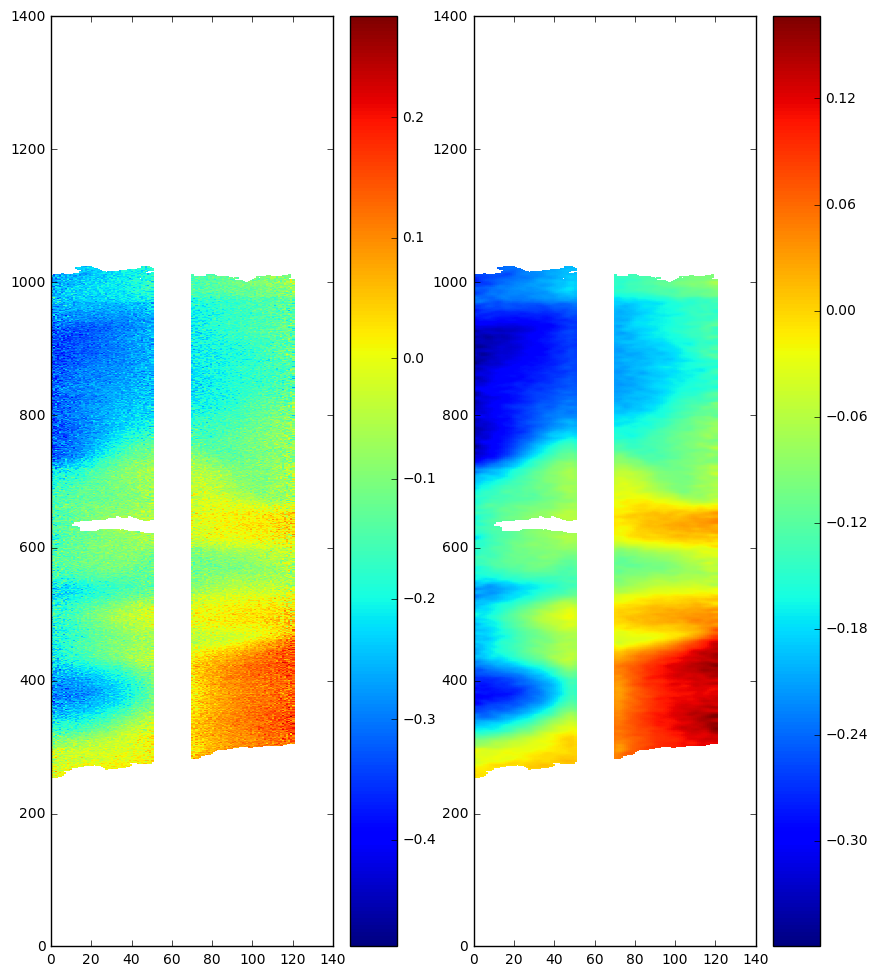

In [17]:
plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(SSH_obs_gap.T)
plt.colorbar()
plt.subplot(122)
plt.pcolor(SSH_obs_filtered.T)
plt.colorbar()

* reg 1 (penalization order 3)

In [18]:
SSH_obs_filtered_reg3, itern_obs_reg3 = filtering(SSH_obs_filtered, mask_gap_land, SSH_obs_gap, lambd=40, regularization_model=1)

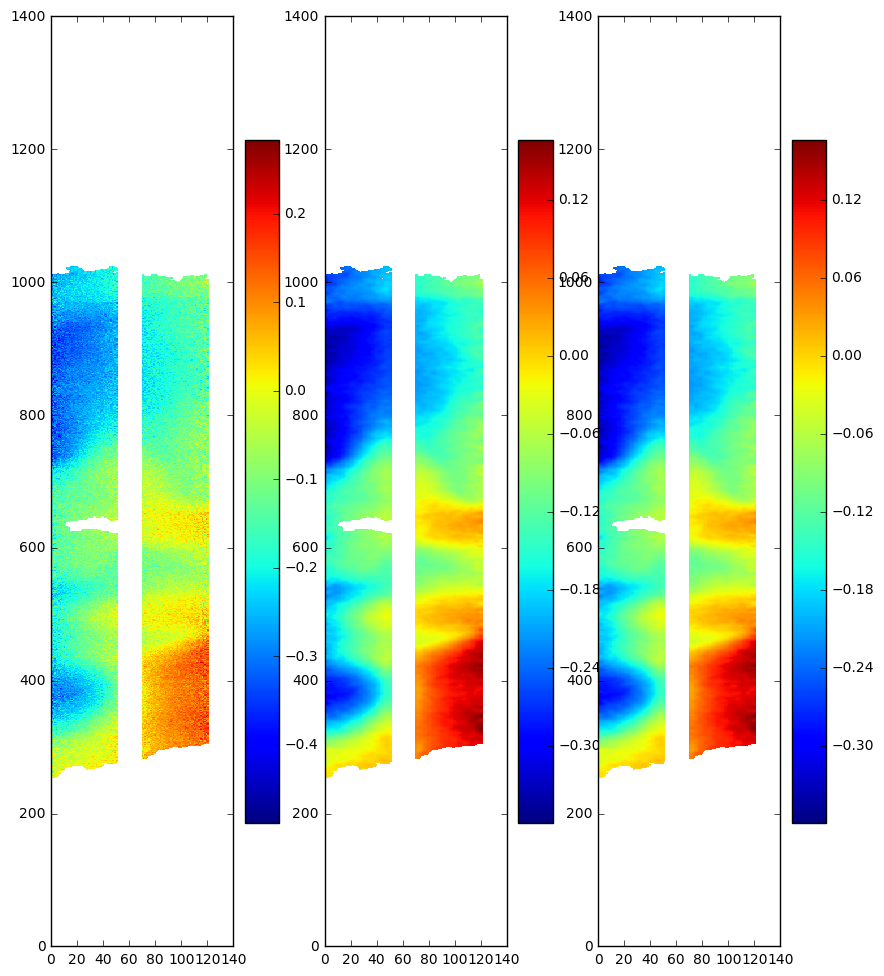

In [19]:
plt.figure(figsize=(10,12))
plt.subplot(131)
plt.pcolor(SSH_obs_gap.T)
plt.colorbar()
plt.subplot(132)
plt.pcolor(SSH_obs_filtered.T)
plt.colorbar()
plt.subplot(133)
plt.pcolor(SSH_obs_filtered_reg3.T)
plt.colorbar()

# --> should actually have the gap filled!

In [20]:
SSH_obs_filtered.mask[mask_gap] = False 

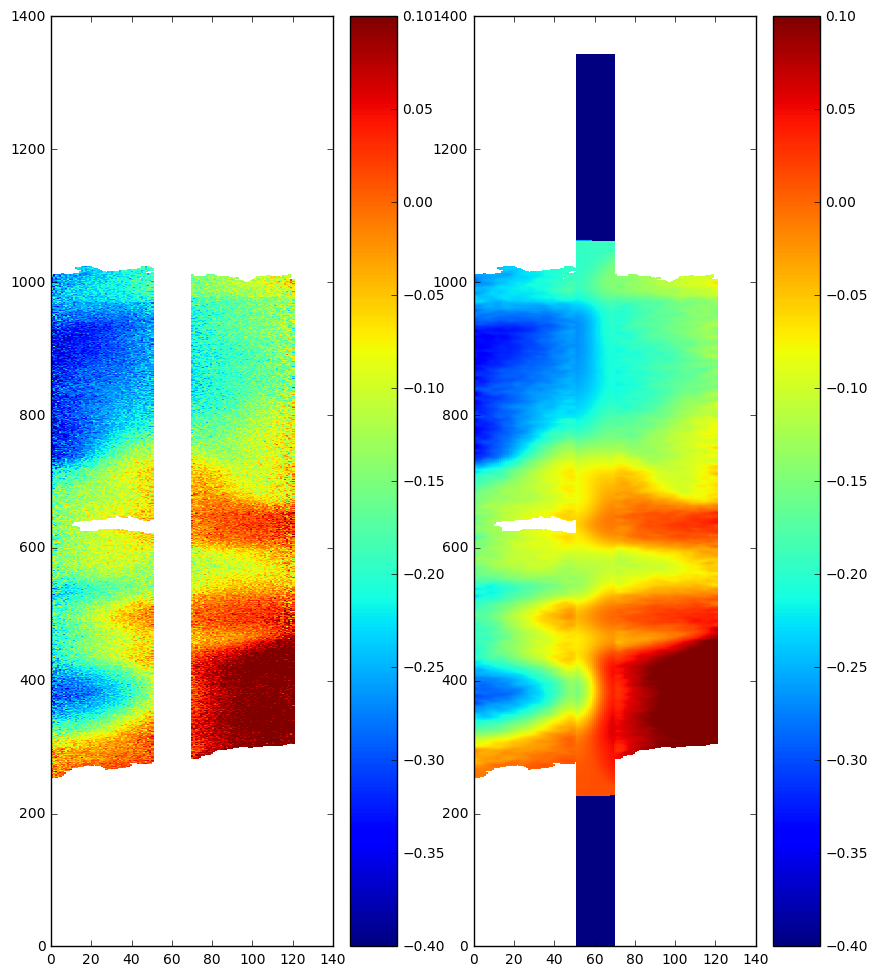

In [21]:
plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(SSH_obs_gap.T, vmin=-.4, vmax=.1)
plt.colorbar()
plt.subplot(122)
plt.pcolor(SSH_obs_filtered.T, vmin=-.4, vmax=.1)
plt.colorbar()

In [22]:
SSH_obs_filtered.mask[mask_land] = True

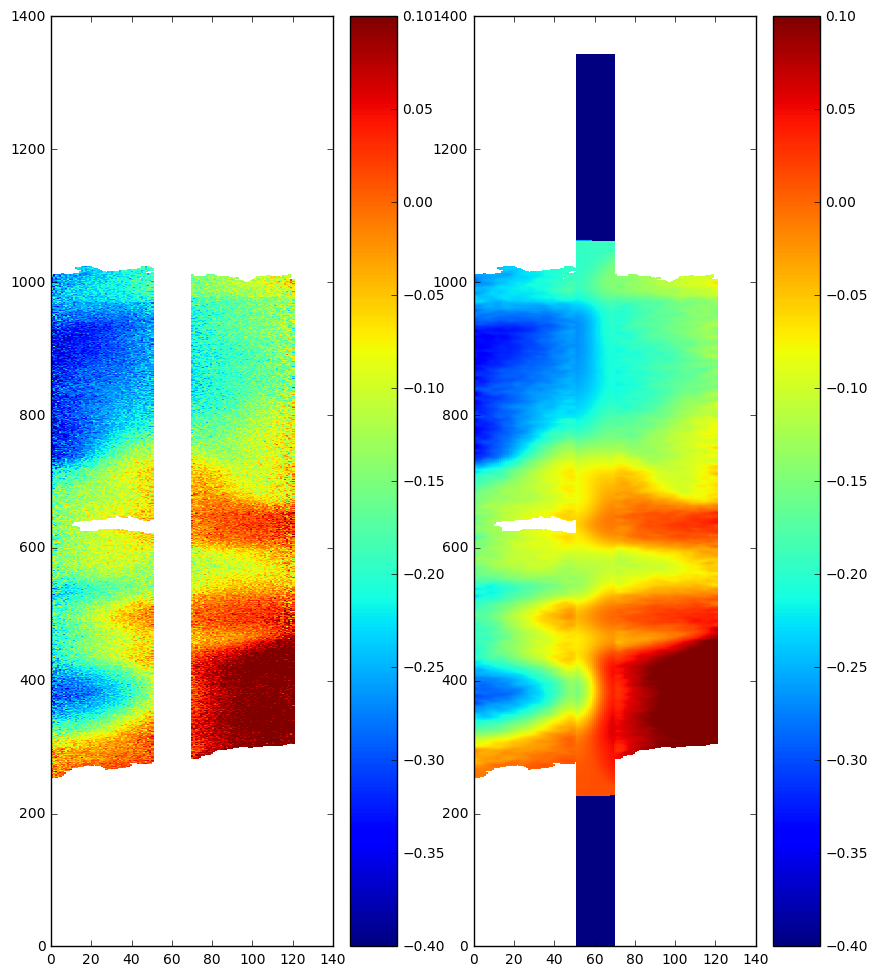

In [23]:
plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(SSH_obs_gap.T, vmin=-.4, vmax=.1)
plt.colorbar()
plt.subplot(122)
plt.pcolor(SSH_obs_filtered.T, vmin=-.4, vmax=.1)
plt.colorbar()

# --> changes nothing to 'activate' land mask.

# --> here we see how the mask of a simulation without gap (e.g. test 6) is necessary to have the mask to be applied after the inpainting 

# Trying to apply mask of test06 to test05:

In [24]:
datadir = '/Users/laura/src/git/swotsimulator/swotoutput/FASTtest06/'
input_filenamec1p09 = 'MED_1km_nogap_JAS12_swotFastPhase_c01_p009.nc'

In [25]:
myfile = datadir + input_filenamec1p09

(0.0, 121.0, 0.0, 1342.0)

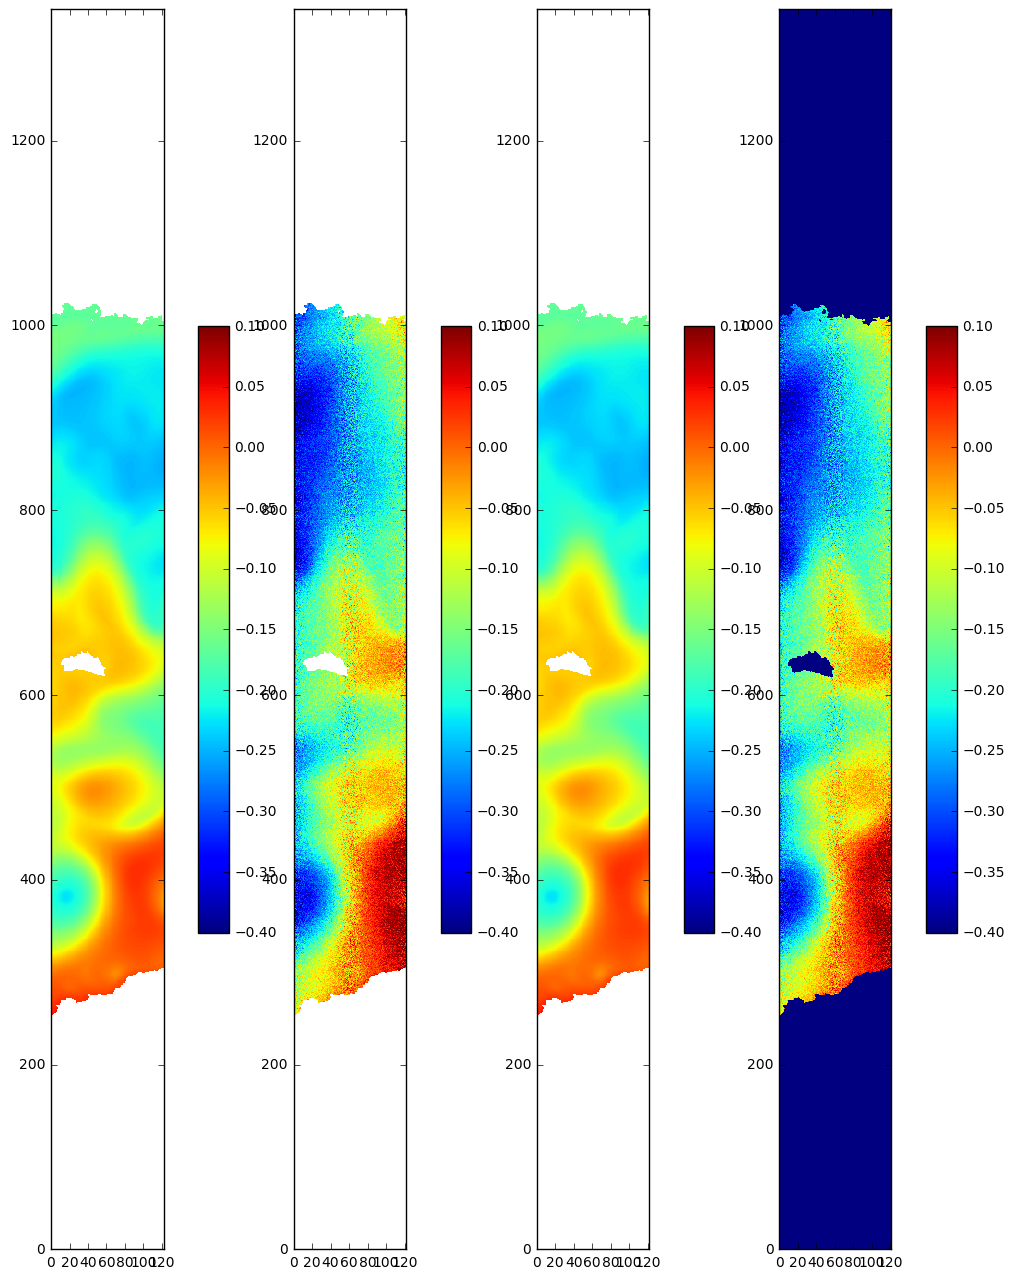

In [36]:
##====================== Load SWOT data ========================

xds = xr.open_dataset(myfile, engine='netcdf4', lock=False)
lon = xds.lon
lat = xds.lat
SSH_model = xds.SSH_model
SSH_obs = xds.SSH_obs
x_ac = xds.x_ac

##=================Preparing the SWOT data arrays===============
# 5. Masking the SWOT outputs
lon = lon.to_masked_array()
lat = lat.to_masked_array()
SSH_model = SSH_model.to_masked_array() 
SSH_obs = SSH_obs.to_masked_array()
x_ac = x_ac.to_masked_array()

SSH_model = np.ma.masked_invalid(SSH_model)
SSH_obs = np.ma.masked_invalid(SSH_obs)

# 2. Flipping the SWOT array: 
# So that lon increases from left to right and lat from bottom to top 
# (depends on if pass is ascending or descending)

lon_dif = lon[0,1] - lon[0,0]
lat_dif = lat[1,0] - lat[0,0]

if (lat_dif<0):
    ## Ascending pass (pass 22 for in the fast-sampling phase)        
    lon = np.flipud(lon)
    lat = np.flipud(lat)
    SSH_model = np.flipud(SSH_model)
    SSH_obs = np.flipud(SSH_obs)
elif (lon_dif<0):
    ## Descending pass (pass 9 for in the fast-sampling phase)
    lon = np.fliplr(lon)
    lat = np.fliplr(lat)
    SSH_model = np.fliplr(SSH_model)
    SSH_obs = np.fliplr(SSH_obs)

# 1. Checking swot array is organized lon, lat: 
lon = np.transpose(lon)
lat = np.transpose(lat)
SSH_model = np.transpose(SSH_model)
SSH_obs = np.transpose(SSH_obs)

# 4. Longitude in -180 : +180 format:
lon[lon > 180] -= 360 

# 3. Fixing the SWOT grid (regular longitude increments, i.e., no jump in swath gap or repeated nadir values)
# At a 1km resolution, should have a size of 121 across track (size of first dim after transposing)    

xx, yy = lon.shape
if (lon[(xx/2)-1, 0] == lon [xx/2, 0]): 
    # if no gap simulaton case need to eliminate repeated nadir value
    lon_nogap = np.delete(lon, (xx/2), axis=0)
    lat_nogap = np.delete(lat, (xx/2), axis=0)
    SSH_model_nogap = np.delete(SSH_model, (xx/2), axis=0)
    SSH_obs_nogap = np.delete(SSH_obs, (xx/2), axis=0)

SSH_model_nogap = np.ma.masked_invalid(SSH_model_nogap)    
SSH_obs_nogap = np.ma.masked_invalid(SSH_obs_nogap)    

plt.figure(figsize=(12, 16))
plt.subplot(141)
plt.pcolor(SSH_model.T, vmin = -.4, vmax=.1)
plt.colorbar()
plt.axis('image')
plt.subplot(142)
plt.pcolor(SSH_obs.T, vmin = -.4, vmax=.1)
plt.colorbar()
plt.axis('image')
plt.subplot(143)
plt.pcolor(SSH_model_nogap.T, vmin = -.4, vmax=.1)
plt.colorbar()
plt.axis('image')
plt.subplot(144)
plt.pcolor(SSH_obs_nogap.T, vmin = -.4, vmax=.1)
plt.colorbar()
plt.axis('image')

In [37]:
SSH_model_nogap.view

<bound method MaskedArray.view of masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]],
       fill_value = 1e+20)
>

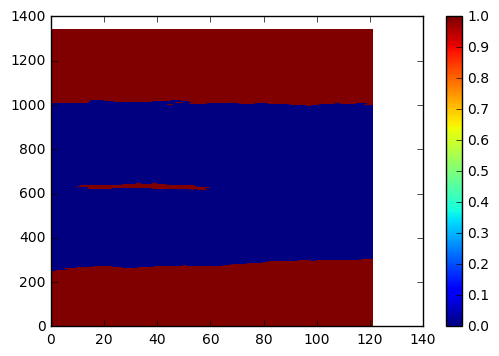

In [38]:
aa = np.zeros_like(SSH_model_nogap)
aa[SSH_model_nogap.mask] = 1.
plt.pcolor(aa.T)
plt.colorbar()

In [39]:
mask_1km_med = SSH_model_nogap.mask

# Apply mask to test 05 (no gap simulation):

In [40]:
SSH_obs_filtered_ma = np.ma.masked_where(mask_1km_med, SSH_obs_filtered)

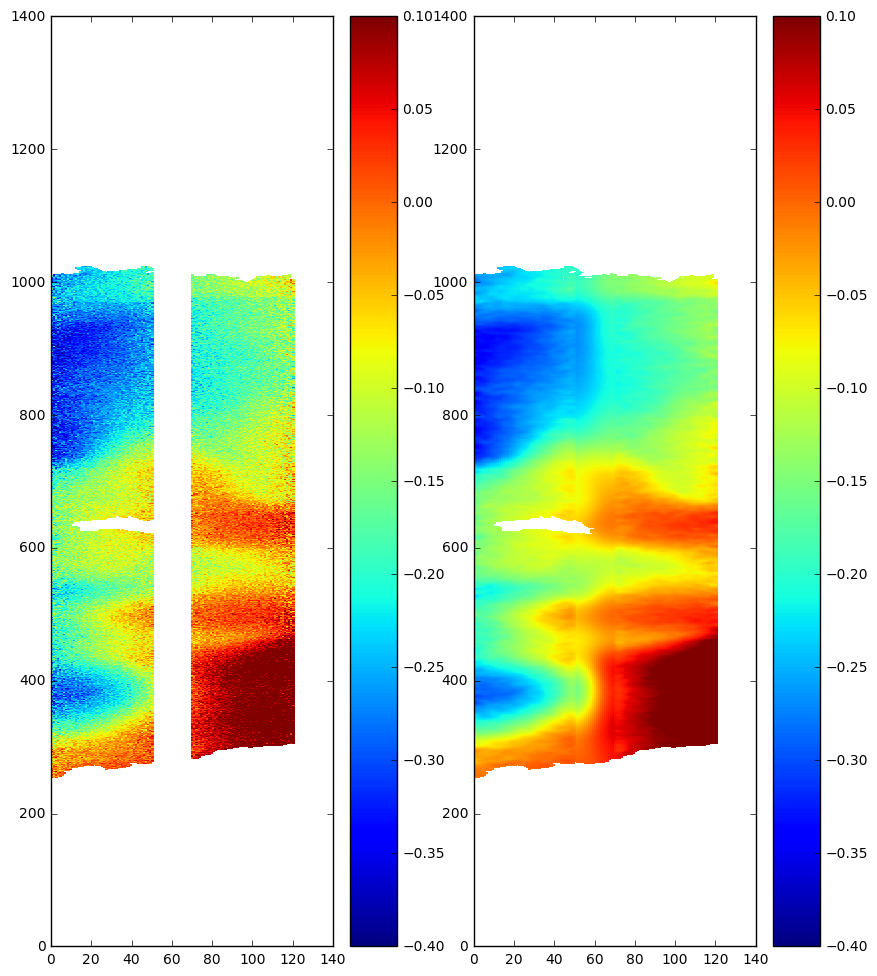

In [41]:
plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolor(SSH_obs_gap.T, vmin=-.4, vmax=.1)
plt.colorbar()
plt.subplot(122)
plt.pcolor(SSH_obs_filtered_ma.T, vmin=-.4, vmax=.1)
plt.colorbar()

# --> works!